In [1]:
import pandas_datareader as data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, InputLayer,
                                     Conv1D, MaxPool1D,
                                     Reshape,
                                     LSTM, GRU)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

**Data (intra-day)**

In [3]:
intraday_data = yf.download(tickers="MSFT",
                            period="2y",
                            interval="1h",
                            auto_adjust=True)
intraday_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2020-08-13 09:30:00-04:00,209.705002,211.289993,208.841003,210.179993,5834629
2020-08-13 10:30:00-04:00,210.190002,210.899994,210.160004,210.625000,2731526
2020-08-13 11:30:00-04:00,210.623703,211.350006,210.449997,211.020004,2402638
2020-08-13 12:30:00-04:00,211.029999,211.279999,209.660004,209.710007,1799662
2020-08-13 13:30:00-04:00,209.740005,209.990005,208.149994,208.970001,3240781


**Microsoft close prices**

In [4]:
pd.options.plotting.backend = "plotly"
intraday_data.plot(y=['Open'])

In [5]:
sequence_opens = intraday_data.values[: , 0]
sequence_opens.shape

(3520,)

**Split and flip data randomly**

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# choose a number of time steps
n_steps = 7
# split into samples
X, y = split_sequence(sequence_opens, n_steps)

In [8]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)
n_train = int(0.8*X.shape[0])
n_val = int(0.9*X.shape[0])
X_train, y_train = X[:n_train, :], y[:n_train]
X_val, y_val = X[n_train:n_val, :], y[n_train:n_val]
X_test, y_test = X[n_val:, :], y[n_val:]

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

### Linear model


In [10]:
model = Sequential()

model.add(Flatten())

model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


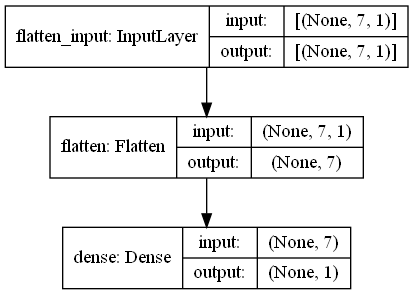

In [11]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

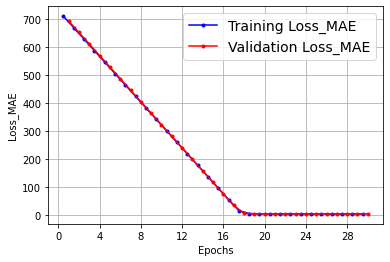

In [12]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

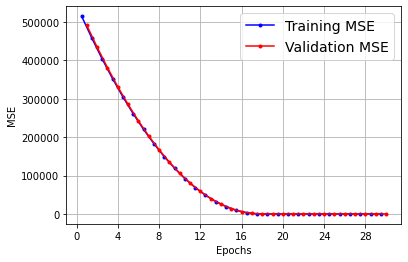

In [13]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 699us/step


Text(0, 0.5, 'Test Values')

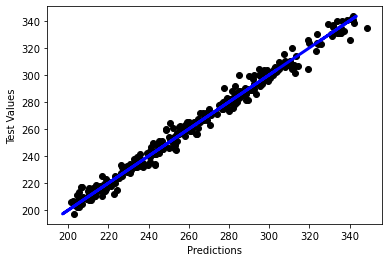

In [14]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

In [15]:
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(y_test, Y_predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, Y_predicted))

Mean squared error: 18.01
Variance score: 0.99


### Deep Neural Network

In [16]:
dnn_hidden_units = [16, 8]

model = Sequential()
for layer in dnn_hidden_units:
    model.add(Dense(units=layer,
                    activation="relu"))

model.add(Flatten())


model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7, 16)             32        
_________________________________________________________________
dense_2 (Dense)              (None, 7, 8)              136       
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 57        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


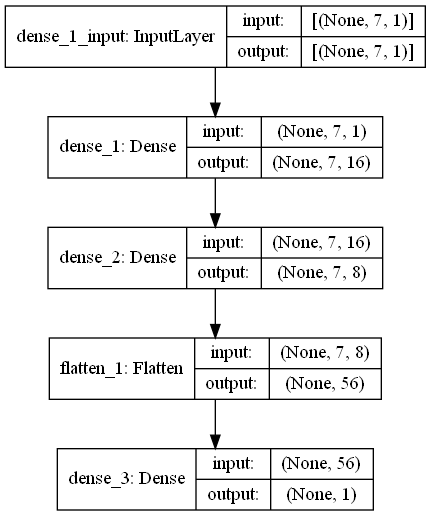

In [17]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

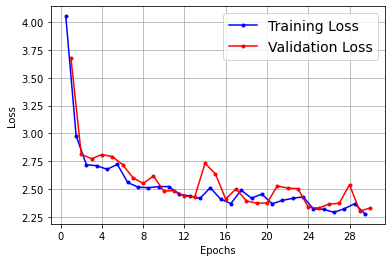

In [18]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

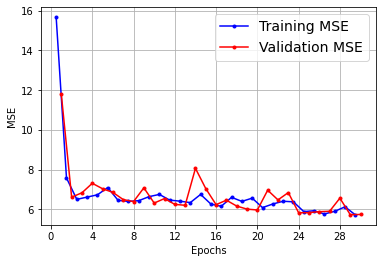

In [19]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 598us/step


Text(0, 0.5, 'Test Values')

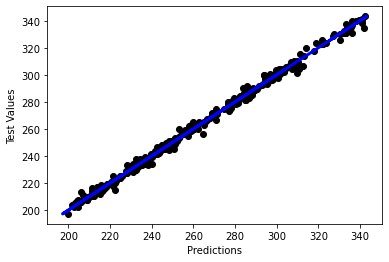

In [20]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

In [21]:
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(y_test, Y_predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, Y_predicted))

Mean squared error: 5.53
Variance score: 1.00


### Last Model (Temporal Convolutional Network with Dilation and causal convolution)


In [22]:
model = Sequential()
model.add(InputLayer(input_shape=[n_steps, 1]))
for dilation_rate in (1, 2, 4):
    model.add(
      Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(Conv1D(filters=64, kernel_size=1))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 64)             2112      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

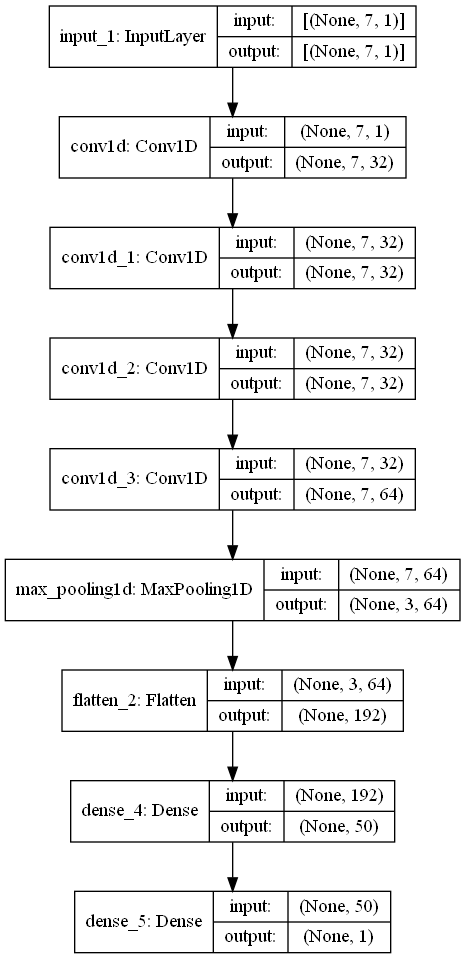

In [23]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=0)

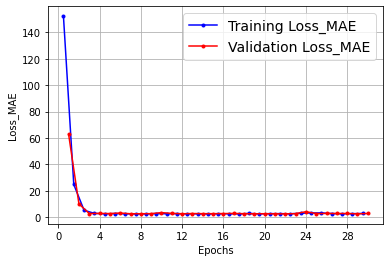

In [25]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 0s 1ms/step - loss: 2.7752 - mse: 13.2834
test loss, test acc: [2.7752130031585693, 13.283356666564941]


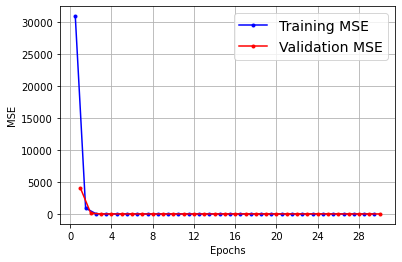

In [27]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

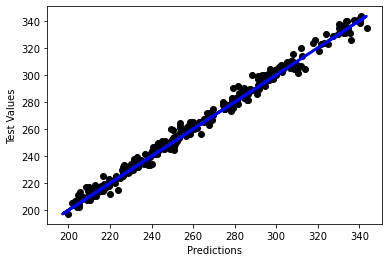

In [28]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

In [29]:
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(y_test, Y_predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, Y_predicted))

Mean squared error: 13.28
Variance score: 0.99
